## Agentic RAG using LangGraph

1. Data Ingestion : Load, chunk and save the embeddings to vector DB
2. Create the llm with retriver tool, grade the retrived documents, and rewrite the question

### 1. Load the enviornment variables (API Keys)

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

### 2. Create llm and embedding model

In [2]:
from langchain_openai import ChatOpenAI
llm=ChatOpenAI()
llm.invoke("Hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bnbb0EsAhM9Ofs3SZ6Mmo440NnMFU', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--74a4d5e3-b94c-4e1c-b70a-ded796436341-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [3]:
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-large",dimensions=1048)
len(embeddings.embed_query("Hi"))

1048

### 3. Data Load, splitting and storing the embdeddings of the splitted chunks into vector DB

In [4]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
urls = [
    "https://www.dailypioneer.com/2025/columnists/developed-india---a-vision-for-a--35-trillion-economy-by-2047.html",
    "https://www.pwc.in/research-and-insights-hub/immersive-outlook/india-at-2047.html",
]

In [6]:
docs = [WebBaseLoader(url).load() for url in urls]

In [7]:
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=25)

In [8]:

docs_list = [item for sublist in docs for item in sublist]

In [9]:
chunks=text_splitter.split_documents(documents=docs_list)

In [10]:
len(chunks)

133

### Create a vector DB

In [11]:
from langchain_community.vectorstores import Chroma

In [12]:
vectorstore=Chroma.from_documents(
    documents=chunks,
    collection_name="rag-chrome",
    embedding=embeddings    
)

In [13]:
retriever=vectorstore.as_retriever()

In [14]:
retriever.invoke("What is India's GDP vision 2047?")

[Document(metadata={'title': 'Developed India:  A Vision for a $35 Trillion Economy by 2047', 'description': 'India has emerged as the fastest-growing major economy in the world, powered by a bold vision of inclusive development and transformative reforms. It is now poised to join the club of developed nations as its GDP is fourth largest in the world\n\nIndia is emerging as an economic superpower. Indiaâ€™s', 'language': 'en', 'source': 'https://www.dailypioneer.com/2025/columnists/developed-india---a-vision-for-a--35-trillion-economy-by-2047.html'}, page_content='For India to reach a developed economy of $35 trillion by 2047, GDP growth of 8 to 11 per cent for 20 years is mandatory for which a holistic and coordinated vision is required. India will become the third-largest economy in the world by 2028. The Indian economy is estimated to be $7 trillion by 2030, $19 trillion by 2040 and $35 trillion by 2047.'),
 Document(metadata={'source': 'https://www.dailypioneer.com/2025/columnists

### 4. Start creating the tools 

In [15]:
from langchain.tools.retriever import create_retriever_tool

In [16]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about India's GDP in 2047",
)

In [17]:
tools = [retriever_tool]

In [18]:
## Convert the tool to a Node 
from langgraph.prebuilt import ToolNode

retriever_node = ToolNode(tools)

In [19]:
llm_with_tool=llm.bind_tools(tools)

In [20]:
llm_with_tool.invoke("What is India's GDP vision 2047?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_WODpEcnlOChAMVjhe9hJmN5H', 'function': {'arguments': '{"query":"India GDP vision 2047"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 72, 'total_tokens': 92, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BnbbDo4XUJF7MPUV21y7jAZNjStrJ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5c382676-791a-48ee-becd-703999c52ed1-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'India GDP vision 2047'}, 'id': 'call_WODpEcnlOChAMVjhe9hJmN5H', 'type': 'tool_call'}], usage_metadata={'input_tokens': 72, 'output_tokens': 20, 'total_tokens': 

### Create Agent

In [21]:
from typing import Annotated, TypedDict, Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

In [22]:
class AgentState(TypedDict):
    messages : Annotated[Sequence[BaseMessage], add_messages]

In [23]:
## Node

def llm_router(state: AgentState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user."""
    
    print("LLM Router ****")
    message=state["messages"]
    last_message=message[-1]
    question=last_message.content
    response=llm_with_tool.invoke(question)
   
    return {"messages":[response]}


In [24]:
from pydantic import BaseModel, Field
class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    grade : str = Field(description="Relavance check 'yes' if relavant else 'no' if not relevant")

In [25]:
GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)

In [ ]:
# def grade_documents(state: AgentState):
#     """Node which will evalute the retrived documents w.r.t the user query if they are relevant or not"""

#     print("*** In Grade Documents***")

#     message=state["messages"]
    
#     question = message[0].content
#     context = message[-1].content
#     prompt= GRADE_PROMPT.format(question=question, context=context)

#     llm_grader = llm.with_structured_output(GradeDocuments)

#     response = llm_grader.invoke({
#          [{"role": "user", "content": prompt}]
#     })
    
#     print("Post invocation")

#     score = response.grade
#     score = "yes"

#     if score == 'yes':
#         return "generate"
#     else:
#         return "rewrite"   


In [69]:
from langchain.prompts import PromptTemplate

In [82]:

def grade_documents(state: AgentState):
    print("----CALL LLM_DECISION_MAKE----")
    llm_with_structure_op=llm.with_structured_output(GradeDocuments)
    
    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
     
    chain=prompt|llm_with_structure_op
     
     
    message=state['messages']
    
    last_message = message[-1]
    
    question = message[0].content
    
    docs = last_message.content
    
    scored_result=chain.invoke({"question": question, "context": docs})
    
    score=scored_result.grade
     
    if score=="yes":
        print("----DECISION: DOCS ARE RELEVANT----")
        return "generate"
    else:
        print("----DECISION: DOCS ARE NOT RELEVANT----")
        return "rewrite"

In [27]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)

def generate_response(state: AgentState):
    """ Node to generate the response for user query based on the retrived data"""
    context=state["messages"][-1].content
    question=state["messages"][0].content
    prompt =  GENERATE_PROMPT.format(question=question, context=context)    
    response = llm.invoke([{"role" : "user", "content": prompt}])
    return {"messages" : [response]}
    


In [28]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)

In [29]:
def rewrite_question(state: AgentState):
    """Rewrite the original question"""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = llm.invoke([{"role" : "user", "content" : prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [48]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import tools_condition

In [83]:
workflow=StateGraph(AgentState)

In [84]:
workflow.add_node("llm_router", llm_router)
workflow.add_node("retriever", retriever_node)
workflow.add_node("generate_response", generate_response)
workflow.add_node("rewrite_question", rewrite_question)


In [85]:
workflow.add_edge(START, "llm_router")


In [86]:
workflow.add_conditional_edges("llm_router", 
                               tools_condition,
                                {
                               "tools":"retriever",
                               END:END
                               })


In [87]:

workflow.add_conditional_edges(
    "retriever",
    grade_documents,
    {
        "generate": "generate_response",
        "rewrite" : "rewrite_question"
    }    
)


In [88]:

workflow.add_edge("rewrite_question", "llm_router")
workflow.add_edge("generate_response", END)

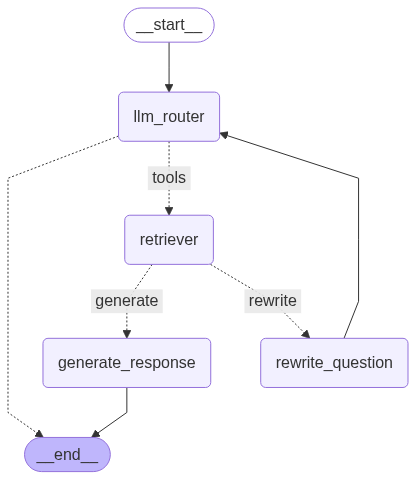

In [89]:
workflow.compile()

In [90]:
app = workflow.compile()

In [93]:
app.invoke({"messages" : "What is India's GDP vision 2047?"})["messages"][-1].content

LLM Router ****
----CALL LLM_DECISION_MAKE----


c:\Users\gauravkkumar\Documents\2025\code\5_agentic_rag\venv\Lib\site-packages\langchain_openai\chat_models\base.py:1772: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


----DECISION: DOCS ARE RELEVANT----


"India's GDP vision for 2047 is to achieve a $35 trillion economy, making it a fully developed nation by its 100th anniversary of independence. The goal involves a holistic and coordinated vision, requiring GDP growth of 8 to 11 per cent for 20 years. India aims to become the third-largest economy in the world by 2028."